# Lab 04 : GatedGCNs for Travelling Salesman Problem - demo



An Efficient Graph Convolutional Network Technique for the Travelling Salesman Problem<br>
CK Joshi, T Laurent, X Bresson<br>
ArXiv preprint: [arXiv:1906.01227](https://arxiv.org/pdf/1906.01227.pdf) <br>


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = '01_GatedGCNs_TSP.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd
    !pip install tensorboardx fastprogress #TSP

In [1]:
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')


# Load config

In [2]:
config_path = "configs/tsp10_small.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))


Loaded configs/tsp10_small.json:
{'expt_name': 'tsp10', 'gpu_id': '0', 'train_filepath': './data/tsp10_small_concorde_train.txt', 'val_filepath': './data/tsp5_val.txt', 'test_filepath': './data/tsp10_small_concorde_test.txt', 'num_nodes': 10, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_edges': 2, 'beam_size': 100, 'hidden_dim': 200, 'num_layers': 10, 'max_epochs': 20, 'batch_size': 100, 'batches_per_epoch': -1, 'accumulation_steps': 10, 'learning_rate': 0.001, 'decay_rate': 1.1}


# Configure GPU options

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id) 

if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)
    

CUDA not available


# Test data creation/reading

Number of batches of size 100: 10
Batch generation took: 0.016 sec
edges: (100, 10, 10)
edges_values: (100, 10, 10)
edges_targets: (100, 10, 10)
nodes: (100, 10)
nodes_target: (100, 10)
nodes_coord: (100, 10, 2)
tour_nodes: (100, 10)
tour_len: (100,)


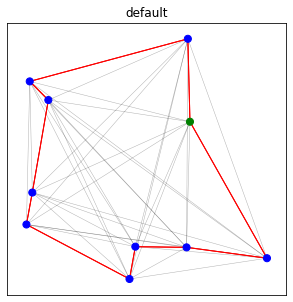

In [4]:
num_nodes = config.num_nodes
batch_size = config.batch_size
train_filepath = config.train_filepath
dataset = GoogleTSPReader(num_nodes, batch_size, train_filepath)
print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

t = time.time()
batch = next(iter(dataset))  # Generate a batch of TSPs
print("Batch generation took: {:.3f} sec".format(time.time() - t))

print("edges:", batch.edges.shape)
print("edges_values:", batch.edges_values.shape)
print("edges_targets:", batch.edges_target.shape)
print("nodes:", batch.nodes.shape)
print("nodes_target:", batch.nodes_target.shape)
print("nodes_coord:", batch.nodes_coord.shape)
print("tour_nodes:", batch.tour_nodes.shape)
print("tour_len:", batch.tour_len.shape)

idx = 0
f = plt.figure(figsize=(5, 5))
a = f.add_subplot(111)
plot_tsp(a, batch.nodes_coord[idx], batch.edges_values[idx], batch.edges_target[idx])


# Instantiate model

In [5]:
# Instantiate the network
net = ResidualGatedGCNModel(config, dtypeFloat, dtypeLong)
if torch.cuda.is_available():
    net.cuda()
#print(net)

# Compute number of network parameters
nb_param = 0
for param in net.parameters():
    nb_param += np.prod(list(param.data.size()))
print('Number of parameters:', nb_param)


Number of parameters: 1657202


# Test forward pass

In [6]:
# Generate a batch of TSPs
num_nodes = config.num_nodes
batch_size = config.batch_size
train_filepath = config.train_filepath
dataset = iter(GoogleTSPReader(num_nodes, batch_size, train_filepath))
batch = next(dataset)

# Convert batch to torch Variables
x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
tour_nodes = Variable(torch.LongTensor(batch.tour_nodes).type(dtypeLong), requires_grad=False)

# Compute class weights
edge_labels = y_edges.cpu().numpy().flatten()
edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
print("Class weights: {}".format(edge_cw))

# Forward pass
y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
loss = loss.mean()
print("Output size: {}".format(y_preds.size()))
print("Loss value:", loss)


Class weights: [0.625 2.5  ]
Output size: torch.Size([100, 10, 10, 2])
Loss value: tensor(0.7414, grad_fn=<MeanBackward0>)


# Test backward pass

In [7]:
# Define optimizer
learning_rate = config.learning_rate
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Backward pass
optimizer.zero_grad()
loss.backward()

# Optimizer step
optimizer.step()

# Compute error metrics 
err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
print("Edge error: {:.3f}\nTour error: {:.3f}\nTSP error: {:.3f}".format(err_edges, err_tour, err_tsp))

# Compute mean predicted and groundtruth tour length
pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
gt_tour_len = np.mean(batch.tour_len) 
print("Predicted tour length: {:.3f}\nGroundtruth tour length: {:.3f}".format(pred_tour_len, gt_tour_len))


Edge error: 62.111
Tour error: 18.800
TSP error: 79.674
Predicted tour length: 17.162
Groundtruth tour length: 2.875


# Training (one epoch)

In [8]:
def train_one_epoch(net, optimizer, config, master_bar):
    
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config.num_nodes
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    train_filepath = config.train_filepath

    # Load TSP data
    dataset = dataset = GoogleTSPReader(num_nodes, batch_size, train_filepath)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        tour_nodes = Variable(torch.LongTensor(batch.tour_nodes).type(dtypeLong), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute mean tour lengths
        pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
        gt_tour_len = np.mean(batch.tour_len)

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()
        running_pred_tour_len += batch_size* pred_tour_len
        running_gt_tour_len += batch_size* gt_tour_len
        running_nb_batch += 1
        
        # Log intermediate statistics
        result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
            loss=running_loss/running_nb_data,
            pred_tour_len=running_pred_tour_len/running_nb_data,
            gt_tour_len=running_gt_tour_len/running_nb_data))
        master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len


def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.1f}h\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               'pred_tour_len:{pred_tour_len:.3f}\t'
               'gt_tour_len:{gt_tour_len:.3f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                   pred_tour_len=pred_tour_len,
                   gt_tour_len=gt_tour_len))
    return result


In [9]:
epoch_bar = master_bar(range(1))
for epoch in epoch_bar:
    train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len = train_one_epoch(net, optimizer, config, epoch_bar)
    epoch_bar.write('t: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len))
    

# Full run

In [10]:
def main(config):
    
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    #print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
 
    # Create log directory
    log_dir = f"./logs/{config.expt_name}/"
    os.makedirs(log_dir, exist_ok=True)
    json.dump(config, open(f"{log_dir}/config.json", "w"), indent=4)
    writer = SummaryWriter(log_dir)  # Define Tensorboard writer

    # Training parameters
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate
    #max_epochs = config.max_epochs
    max_epochs = 10
    num_nodes = config.num_nodes
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    best_pred_tour_len = 1e6  # For saving checkpoints

    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    epoch_bar = master_bar(range(max_epochs))
    for epoch in epoch_bar:
        
        # Log to Tensorboard
        writer.add_scalar('learning_rate', learning_rate, epoch)
        
        # Train
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len = train_one_epoch(net, optimizer, config, epoch_bar)
        epoch_bar.write('t: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len))
        writer.add_scalar('loss/train_loss', train_loss, epoch)
        writer.add_scalar('pred_tour_len/train_pred_tour_len', train_pred_tour_len, epoch)
        writer.add_scalar('optimality_gap/train_opt_gap', train_pred_tour_len/train_gt_tour_len - 1, epoch)
        
    return net

net = main(config)


Number of parameters: 1657202


# Visualize model predictions

Predicted tour length: 3.016 (mean)
Groundtruth tour length: 3.016 (mean)


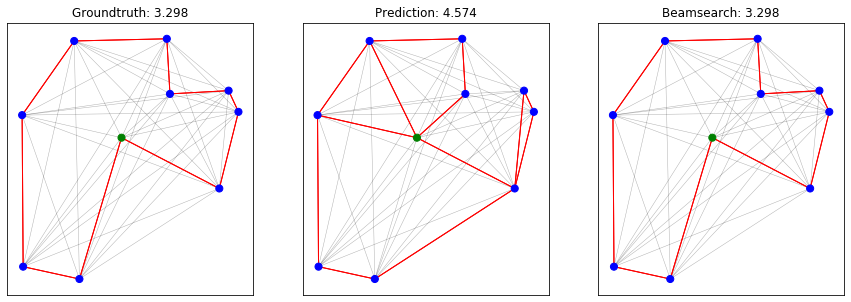

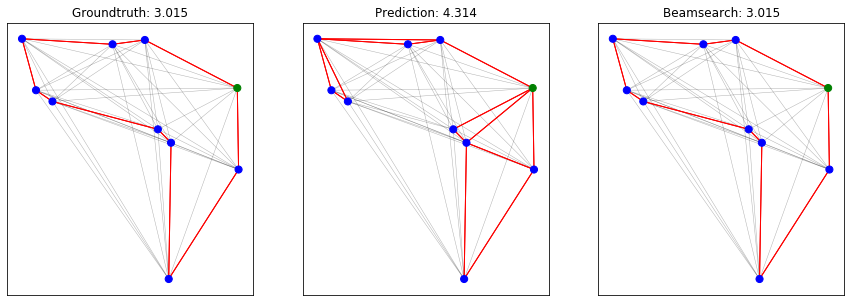

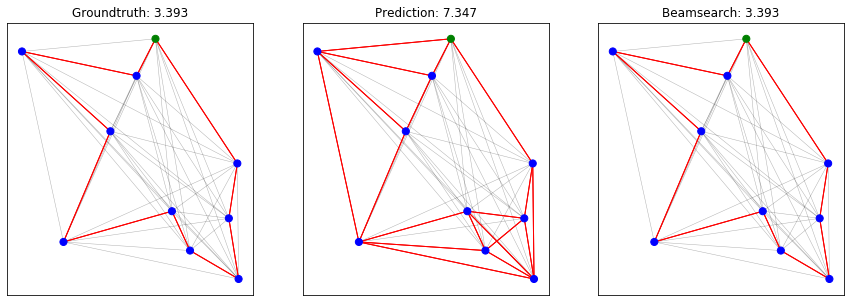

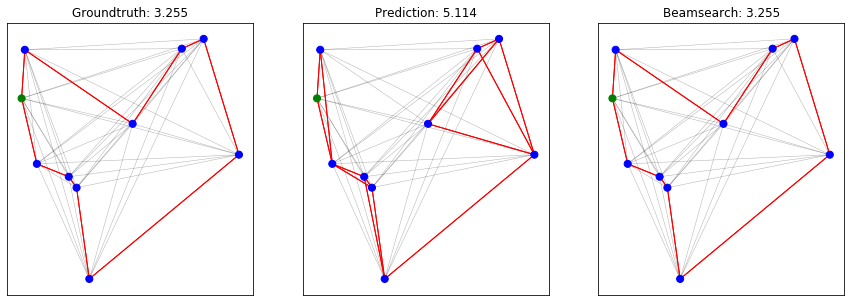

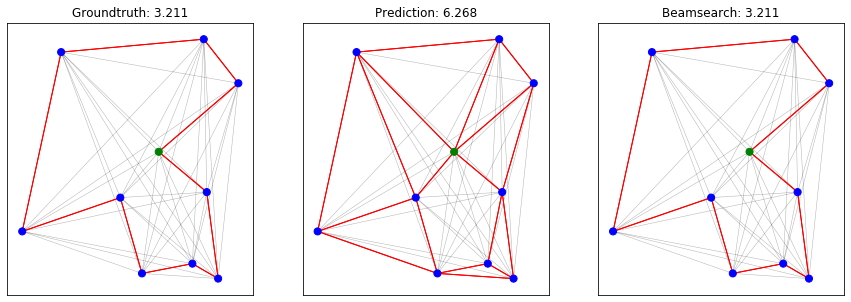

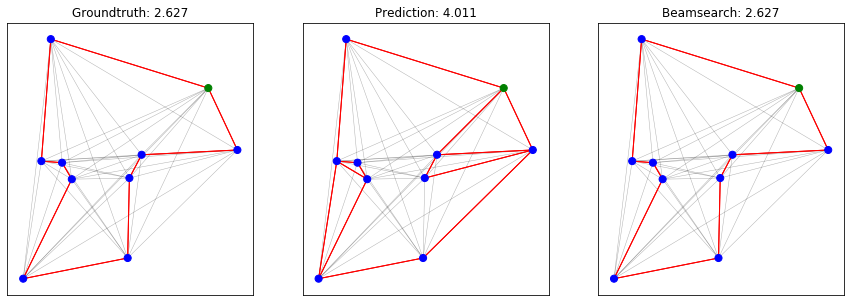

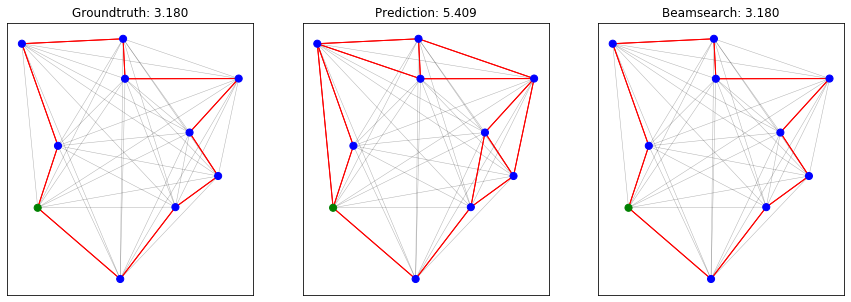

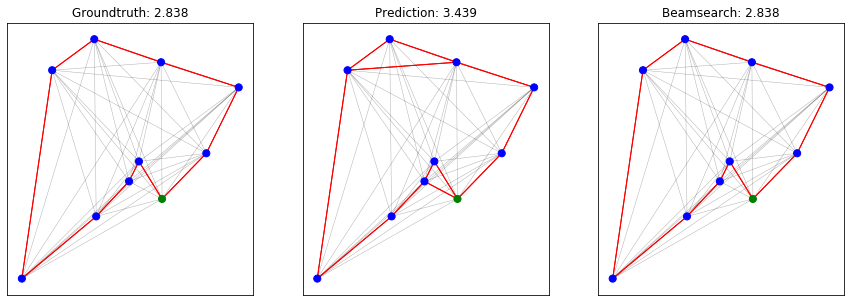

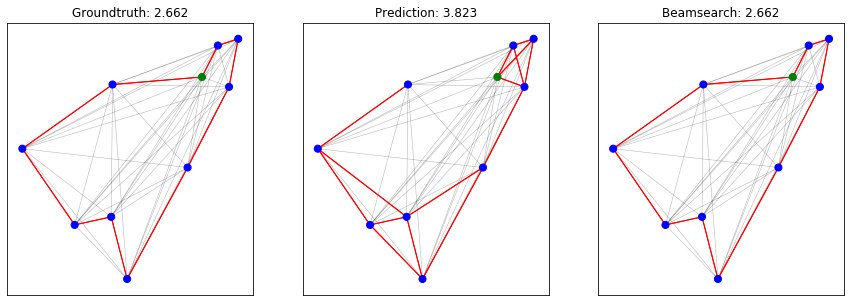

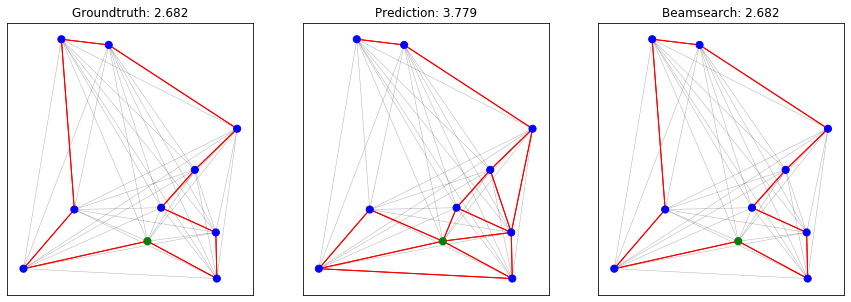

In [11]:

# Set evaluation mode

net.eval()

batch_size = 10
beam_size = config.beam_size
test_filepath = config.test_filepath
test_filepath = 'data/tsp10_small_concorde_test.txt'
dataset = iter(GoogleTSPReader(num_nodes, batch_size, test_filepath))
batch = next(dataset)

with torch.no_grad():
    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
    tour_nodes = Variable(torch.LongTensor(batch.tour_nodes).type(dtypeLong), requires_grad=False)

    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
    loss = loss.mean()

    if beam_size != -1:
        # Get batch beamsearch tour prediction
        bs_nodes = beamsearch_tour_nodes_shortest(
            y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
        # Compute mean tour length
        pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
    else:  # Do not perform beamsearch
        pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
    gt_tour_len = np.mean(batch.tour_len)
    print("Predicted tour length: {:.3f} (mean)\nGroundtruth tour length: {:.3f} (mean)".format(pred_tour_len, gt_tour_len))

    # Sanity check
    for idx, nodes in enumerate(bs_nodes):
        if not is_valid_tour(nodes, num_nodes):
            print(idx, " Invalid tour: ", nodes)

    # Plot some predictions
    plot_predictions_beamsearch(x_nodes_coord, x_edges_values, y_edges, y_preds, bs_nodes, num_plots=10)
    
    